---
title: "Association testing"
---


---
format:
  html:
   code-fold: false
   toc: true
  ipynb:
    toc: true
    number-sections: false
bibliography: references/references_5.bib
---

::: {.callout-note title="Important notes for this notebook" icon=false}

After QC and generating MDS components as covariates to address population structure, the data is ready for association tests. In this tutorial, we provide scripts for association tests suitable for binary traits (e.g., alcohol-dependent patients vs. healthy controls) or quantitative traits (e.g., number of alcoholic beverages consumed per week).

## Learning outcomes

- **Discuss** different types of association tests
- **Identify** the suitable association test for your data

## How to make this notebook work

* In this notebook, we will use both `R` and `bash command line` programming languages. Remember to **change the kernel** whenever you transition from one language to the other (`Kernel --> Change Kernel`) indicated by the languages' images. We will first run `Bash` commands.  
  
<img src="Images/bash.png" alt="Bash" width="80"> Choose the Bash kernel
 
:::

:::{.callout-note title="Some theory"}

### Biometric model

The theory behind genetic association is rooted in the biometrical model, first established by Fisher. According to this model, each genetic variant has an additive effect on a trait's value. For a specific variant and its genotypes, each genotype contributes differently to the trait. For example, in a two-allele system (A and a), the effects of the three genotypes (`AA, Aa, a`) are defined by two parameters: *d* (twice the difference between the homozygotes, AA and aa) and *h* (the effect of the heterozygote, Aa). The mean effect of the homozygotes is *m*. These parameters, *d* and *h*, are called genotypic effects [@neale2013methodology].

![Figure 3.1. Biometrical genetics. The d and h increments of the gene difference A – a. Aa may lie on either side of m and the sign of h will vary accordingly; in the case illustrated h would be negative (adapted from Mather and Jinks, 1977, p. 32).](Images/biometric.png){fig-align="center" label="fig-biometricmodel"}

#### Example 

Imagine that we are talking about genes that influence adult stature. Let us assume that the normal range for males is from 1.47m to 2m: that is, about **0.56m**. Let's assume that each somatic chromosome has one gene of roughly equivalent effect. Then, in each locus, the **homozygotes contribute ±d=±0.28 cm** (from the midpoint, *m*), depending on whether they are *AA*, the increasing homozygote, or *aa*, the decreasing homozygote. While some loci may have larger effects, others are likely to have smaller contributions. This model suggests that the effect of any given gene is subtle and difficult to detect using classical genetic methods.

:::

In GWAS, linear models have been typically used for continuous phenotypes  (e.g. BMI, height, blood pressure) and logistic models for binary traits (e.g. disease presence). These models account for fixed effects (such as genotype) but also need to consider random effects, represented as an error term, $e$, to minimize the influence of covariates, like sex of population structure. 

Linear mixed models (LMMs) are increasingly popular as an alternative to standard linear models and have proven to be effective for analyzing complex traits. They adjust for confounding factors such as population stratification, family structure, and cryptic relatedness, resulting in more reliable test statistics. However, they are usually more computationally demanding.

# 6.1 Modelling


### The linear regression model

The basic linear regression model is written as:

$$y = G\beta_G + X\beta_X + \epsilon$$

Here, $y$ is the phenotype vector, $G$ is the genotype/dosage matrix (the allele counts) for the current variant, $X$ is the fixed-covariate matrix, and $e$ is the error term subject to least-squares minimization. 


PLINK supports SNP-trait association testing for both quantitative and binary traits:

* `-assoc`: It performs chi-square tests for binary traits. For quantitative traits, it uses asymptotic methods (likelihood ratio test or Wald test) or empirical significance values. Covariates are not supported. It will automatically treat outcomes as quantitative when the phenotype column contains values other than 1, 2, 0, or missing. 
* `--linear`: Fits linear regression models for quantitative traits, allowing covariates.
* `--logistic`: Fits or Firth logistic regression models for binary traits, supporting covariates and SNP-covariate interactions.

Both `--linear` and `--logistic` are more flexible than `--assoc` but may run slower. Further details are available in PLINK's documentation. For detailed information on PLINK's association methods, visit PLINK Association Analysis [PLINK 1.9](https://www.cog-genomics.org/plink/1.9/assoc) or [PLINK 2.0](https://www.cog-genomics.org/plink/2.0/assoc). Note that command options differ between versions. 

### PLINK in association testing

PLINK performs one degree of freedom (1 df) chi-square allelic test in which the trait value, or the log‐odds of a binary trait, increases or decreases linearly as a function of the number of risk alleles. This basic biallelic test will compare the frequency of the alleles in cases vs. controls. All models are tests for the minor allele *a*: 
* allelic association test, 1 df: *a* vs. *A*
  
In addition, non‐additive tests are available:
* dominant gene action test, 1 df: (*aa* & *Aa*) vs *AA*
* recessive gene action test, 1 df: aa vs (*Aa* & *AA*)
* genotypic association test, 2 df: *aa* vs *Aa* vs *AA*

However, non‐additive tests are not widely applied, because the statistical power to detect non‐additivity is low in practice. More complex analyses (e.g., Cox regression analysis) can be performed by using R‐based “plug‐in” functions in PLINK.


### 6.1.1 Analysis with PLINK

<img src="Images/bash.png" alt="Bash" width="40"> Switch to the Bash kernel.

We link the data folder again and create a folder for output files. 

In [5]:
ln -sf ../Data
mkdir -p Results/GWAS5

Recall that our dataset contains **binary** traits: phenotype can take two values 0 or 1. In this tutorial, we will apply both `--assoc` and `--logistic` to our data. A reminder that the `-assoc` option does not allow correct covariates such as principal components (PCs)/MDS components for population stratification makes it less suited for association analyses. However, we will look at the results for educational purposes.

We start with `--assoc`:

In [2]:
plink --bfile Results/GWAS4/HapMap_3_r3_10 --assoc --out Results/GWAS5/assoc_results --silent

Let's have a look at the association output file:

In [8]:
head -5 Results/GWAS5/assoc_results.assoc

 CHR         SNP         BP   A1      F_A      F_U   A2        CHISQ            P           OR 
   1   rs3131972     742584    A   0.1944   0.1455    G       0.9281       0.3354        1.418 
   1   rs3131969     744045    A   0.1759      0.1    G        2.647       0.1037        1.921 
   1   rs1048488     750775    C   0.1981   0.1455    T        1.054       0.3045        1.451 
   1  rs12562034     758311    A  0.06481   0.1182    G        1.863       0.1723       0.5171 


where the columns represent:

* `CHR`	Chromosome code  
* `SNP`	Variant identifier  
* `BP`	Base-pair coordinate  
* `A1`	Allele 1 (usually minor)  
* `F_A`	Allele 1 frequency among cases  
* `F_U`	Allele 1 frequency among controls  
* `A2`	Allele 2  
* `CHISQ`	Allelic test chi-square statistic
* `P`	Allelic test p-value. The p-value indicates the probability that the observed association (or one more extreme) would occur by chance if there is no true association between the SNP and the trait.
* `OR` odds(allele 1 | case) / odds(allele 1 | control)  

Next, we use the `--logistic` and `--covar` options to provide the MDS components `covar_mds.txt` as covariates (from the previous tutorial). We remove rows with NA values from the output to prevent issues during plotting.

In [14]:
# --logistic 
# Note, we use the option --hide-covar to only show the additive results of the SNPs in the output file.
plink --bfile Results/GWAS4/HapMap_3_r3_10 --covar Results/GWAS4/covar_mds.txt --logistic hide-covar --out Results/GWAS5/logistic_results --silent

# Remove NA values, those might give problems generating plots in later steps.
awk '!/'NA'/' Results/GWAS5/logistic_results.assoc.logistic > Results/GWAS5/logistic_results.assoc_2.logistic

In addition to the columns (CHR, SNP, BP, A1, OR, and P) also present in the `--assoc` output, new columns include:

- `TEST`: type of test performed. It usually includes "ADD" (additive model) but may also include other genetic models depending on the options specified (e.g., dominant, recessive).
- `NMISS`: number of non-missing observations (individuals) used in the analysis for that particular SNP.
- `STAT`: the test t-statistic for the logistic regression test

In [10]:
head -5 Results/GWAS5/logistic_results.assoc.logistic

 CHR         SNP         BP   A1       TEST    NMISS         OR         STAT            P 
   1   rs3131972     742584    A        ADD      109      1.782        1.363       0.1729
   1   rs3131969     744045    A        ADD      109      2.195        1.705      0.08811
   1   rs1048488     750775    C        ADD      108      1.801         1.39       0.1644
   1  rs12562034     758311    A        ADD      109     0.4209       -1.526        0.127


The results of these GWAS analyses will be visualized in the final step, highlighting any genome-wide significant SNPs in the dataset.

:::{.callout-note}

For quantitative traits the option `--logistic` should be replaced by `--linear`. 

:::


# 6.2 Correction for multiple testing

Modern genotyping arrays can test up to 4 million markers, increasing the risk of false positives due to multiple testing. While a single comparison has a low error rate, analyzing millions of markers amplifies this risk. Common methods to address this include:

- **Bonferroni Correction**: Adjusts the p-value threshold by dividing $0.05$ by the number of tests, controlling false positives. It controls the probability of at least one false positive but may be overly strict due to SNP correlation caused by linkage disequilibrium (hence, increased FN).
- **False Discovery Rate (FDR)**: Minimizes the proportion of false positives among significant results (specified threshold) being less conservative than Bonferroni. However, it assumes SNP independence, which may not hold with LD.
- **Permutation Testing**: Randomizes outcome labels to generate an empirical null distribution, enabling robust p-value adjustments. This process is repeated extensively (often millions of times) to eliminate true associations.

To learn more about statistical testing and false positives, [look at this online book chapter](https://web.stanford.edu/class/bios221/book/06-chap.html).

Before executing PLINK's command for multiple testing, answer the questions below.

:::{.callout-important title="Stop - Read - Solve"}

The Bonferroni-corrected p-value threshold is calculated using an initial threshold of 0.05. 
1. Determine the new BF threshold for this dataset.
2. How many SNPs in your dataset appear to be significantly associated with the phenotype using this threshold, and how many would be considered significant without the multiple testing correction?

Hint: 
- 1. Apply the formula: bonferroni_threshold <- alpha / num_snps. You can get the number of SNPs from `Results/GWAS4/HapMap_3_r3_10.bim`. Use Python or R
- 2. P-values from the association test are in column 9 (`Results/GWAS5/assoc_results.assoc`), check how many SNPs would pass the two different thresholds. 

:::

In [10]:
# Write code here and change kernel accordingly 


:::{.callout-tip title="Solution" collapse=true}

- BF P-value: $4.7e-08$. 
- 55433 SNPs are significant with $0.05$ cutoff and 0 would be with $4.7e-08$.

:::


In [11]:
wc -l Results/GWAS4/HapMap_3_r3_10.bim

1073788 Results/GWAS4/HapMap_3_r3_10.bim


<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

In [1]:
result <- 0.05 / 1073788
format(result, scientific = TRUE, digits = 2)

[1] "4.7e-08"

<img src="Images/bash.png" alt="Bash" width="40"> Switch to the Bash kernel.


In [12]:
awk '$9 < 0.05' Results/GWAS5/assoc_results.assoc | wc -l 

55433


In [13]:
awk '$9 < 4.7e-08' Results/GWAS5/assoc_results.assoc | wc -l 

0


****

### 6.3.1 Commands

We know that no SNPs would pass the strict BF cutoff, is this also the case for other correction approaches?

#### Adjustment for multiple testing 

PLINK's `--adjust` option will generate a file containing the adjusted significance values for several multiple correction approaches, saved to `Results/GWAS5/adjusted_assoc_results.assoc.adjusted`: 

In [14]:
# --adjust
plink --bfile Results/GWAS4/HapMap_3_r3_10 -assoc --adjust --out Results/GWAS5/adjusted_assoc_results --silent

Now, let's look at the output file from PLINK

In [1]:
head -n5 Results/GWAS5/adjusted_assoc_results.assoc.adjusted

 CHR         SNP      UNADJ         GC       BONF       HOLM   SIDAK_SS   SIDAK_SD     FDR_BH     FDR_BY
   3   rs1097157   1.66e-06  1.861e-06          1          1     0.8318     0.8318     0.2872          1 
   3   rs1840290   1.66e-06  1.861e-06          1          1     0.8318     0.8318     0.2872          1 
   8    rs279466  2.441e-06  2.727e-06          1          1     0.9273     0.9273     0.2872          1 
   8    rs279460  2.441e-06  2.727e-06          1          1     0.9273     0.9273     0.2872          1 


which contains the fields: 
- CHR         Chromosome number
- SNP         SNP identifier
- UNADJ       Unadjusted p-value
- GC          Genomic-control corrected p-values
- BONF        Bonferroni single-step adjusted p-values
- HOLM        Holm (1979) step-down adjusted p-values
- SIDAK_SS    Sidak single-step adjusted p-values
- SIDAK_SD    Sidak step-down adjusted p-values
- FDR_BH      Benjamini & Hochberg (1995) step-up FDR control
- FDR_BY      Benjamini & Yekutieli (2001) step-up FDR control 

The Bonferroni correction for all SNPs (`BONF`) gives a value of 1, indicating that the SNP is not significantly associated with the phenotype based on the threshold $0.05/n$. As mentioned earlier, this suggests that the method might be too conservative, potentially leading to a high number of false negatives (Type II errors).

However, this is not the case for the Benjamini & Hochberg method of FDR (`FDR-BH`).  

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.


In the code below, we will plot the distribution of `FDR-BH` values to illustrate this. 

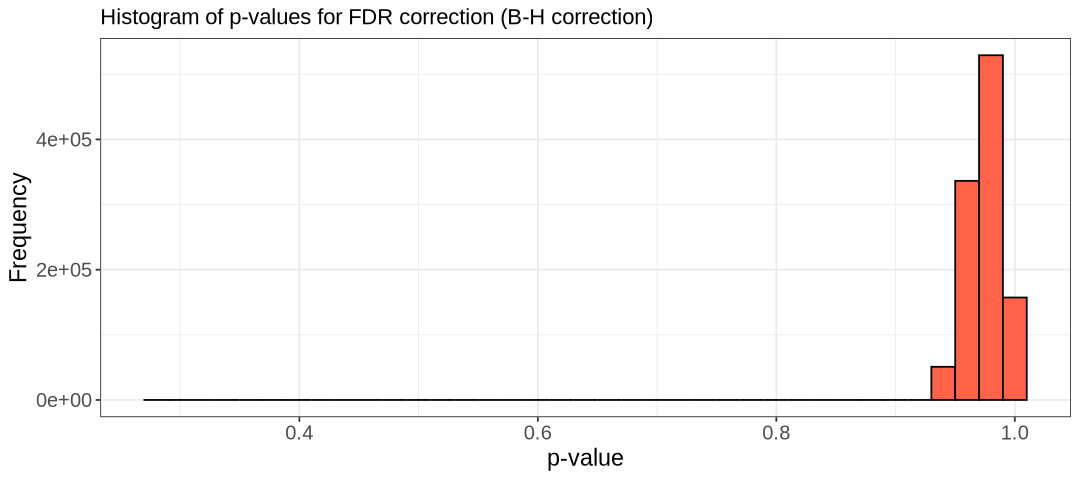

In [4]:
suppressMessages(suppressWarnings(library(ggplot2)))

options(repr.plot.width = 9, repr.plot.height = 4)

tests <- read.table("Results/GWAS5/adjusted_assoc_results.assoc.adjusted", header=T)

hist.relatedness <- ggplot(tests, aes(x=FDR_BH)) +
  geom_histogram(binwidth = 0.02, col = "black", fill="tomato") + 
  labs(title = "Histogram of p-values for FDR correction (B-H correction)") + 
  xlab("p-value") + 
  ylab("Frequency") + 
  theme_bw() +
  theme(axis.title=element_text(size=14), axis.text=element_text(size=12))

show(hist.relatedness)

# Write code here


:::{.callout-important title="Stop - Read - Solve"}
In the R code above, use the `summary()` to get an overview of the distribution of `FDR-BH` values. 
- What is the minimum FDR-adjusted p-value? and the mean FDR-adjusted p-value?
- Are there any SNPs significantly associated with the phenotype after applying genome-wide correction?
:::

##### Write your answer here

:::{.callout-tip title="Solution"}

In R: `summary(tests$FDR_BH)`

```
Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.2872  0.9647  0.9742  0.9710  0.9742  1.0000 
```

The black line shows very few values with an FDR-adjusted p-value below ~0.95, with the lowest around 0.29 (as shown in the summary table). Therefore, no variants are significant at the 0.05 level after genome-wide correction.

:::

***

#### Permutation
Let's perform a permutation correction. This is a computationally intensive approach, so we will run it on a subset of the data to reduce the computational time (e.g. chr 22). We need the option `--mperm` to define how many permutations we want to do.

First, we generate a subset the data: 

In [1]:
awk '{ if ($1 == 22) print $2 }' Results/GWAS4/HapMap_3_r3_10.bim > Results/GWAS5/subset_snp_chr_22.txt

plink --bfile Results/GWAS4/HapMap_3_r3_10 --extract Results/GWAS5/subset_snp_chr_22.txt --make-bed \
--out Results/GWAS5/HapMap_subset_for_perm --silent

Then, we perform 100K permutations (usually you'd more):

In [4]:
plink --bfile Results/GWAS5/HapMap_subset_for_perm --assoc --mperm 1000000 --threads 4 \
--out Results/GWAS5/perm_result --silent

The`EMP1` indicates the empirical p-value and `EMP2` the corrected one. We can check the ordered permutation results: 

In [1]:
sort -gk 4 Results/GWAS5/perm_result.assoc.mperm | head -n5

 CHR          SNP         EMP1         EMP2 
  22    rs4821137    0.0001075       0.5387 
  22   rs11704699     4.05e-05       0.7743 
  22     rs910541    0.0002605       0.8236 
  22    rs4821138    0.0001995       0.9045 


:::{.callout-important title="Stop - Read - Solve"}

Are there any significant SNPs? Hint: generate an overview of the distribution of `EMP2` values 

:::

In [7]:
# Write your code here

:::{.callout-tip title="Solution"}

Again, we do not infer any significance from the permutation correction. Let's use the `summary()` function and visualize the values. 

:::

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5387  1.0000  1.0000  0.9999  1.0000  1.0000 

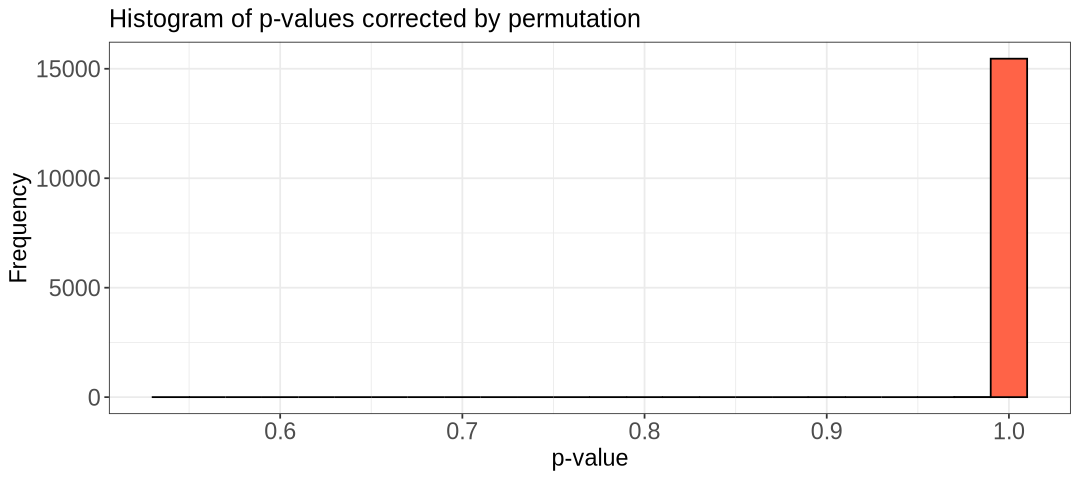

In [6]:
suppressMessages(suppressWarnings(library(ggplot2)))

options(repr.plot.width = 9, repr.plot.height = 4)

tests <- read.table("Results/GWAS5/perm_result.assoc.mperm", header=T)

hist.relatedness <- ggplot(tests, aes(x=EMP2)) +
  geom_histogram(binwidth = 0.02, col = "black", fill="tomato") + 
  labs(title = "Histogram of p-values corrected by permutation") + 
  xlab("p-value") + 
  ylab("Frequency") + 
  theme_bw() +
  theme(axis.title=element_text(size=14), axis.text=element_text(size=14), plot.title=element_text(size=15))


show(hist.relatedness)

summary(tests$EMP2)

In summary, when correcting for multiple testing, it is crucial to remember that different correction methods have distinct properties. It is the responsibility of the investigator to choose the appropriate method and interpret the results accordingly. Generally, permutation correction is considered the gold standard in GWAS analysis, though it may not always be effective with certain statistical models (@joo_multiple_2016, @uffelmann_genome-wide_2021), a limitation to be mindful of.

Further pros and cons of this method, which can be used for association and dealing with multiple testing, are described in this article [@marees2018tutorial].

In [10]:
awk '$9 < 0.05' Results/GWAS5/logistic_results.assoc.logistic | wc -l

62220


In [12]:
head Results/GWAS5/logistic_results.assoc.logistic.adjusted

 CHR         SNP      UNADJ         GC       BONF       HOLM   SIDAK_SS   SIDAK_SD     FDR_BH     FDR_BY
   3   rs9853565  3.672e-05  0.0001022          1          1          1          1     0.8617          1 
  16  rs17688919  3.743e-05  0.0001039          1          1          1          1     0.8617          1 
   2   rs4519515  4.213e-05  0.0001155          1          1          1          1     0.8617          1 
   2    rs342094  4.321e-05  0.0001181          1          1          1          1     0.8617          1 
  11   rs4936795  4.854e-05  0.0001311          1          1          1          1     0.8617          1 
   6   rs4490696  5.247e-05  0.0001405          1          1          1          1     0.8617          1 
  11   rs2000796  5.359e-05  0.0001431          1          1          1          1     0.8617          1 
  11   rs7941914  6.083e-05  0.0001603          1          1          1          1     0.8617          1 
   3   rs7624706   6.87e-05  0.0001786         

### Manhattan and QQ-plots

We can make suggestions for the presence of high-association alleles using a visual approach. The first is called a **Manhattan plot**. The idea is straightforward: for each SNP, we plot it against the negative log of its p-value from the test of association [@gibson2010hints]. We can generate these plots with the `R` package `qqman` using the `manhattan()` function.

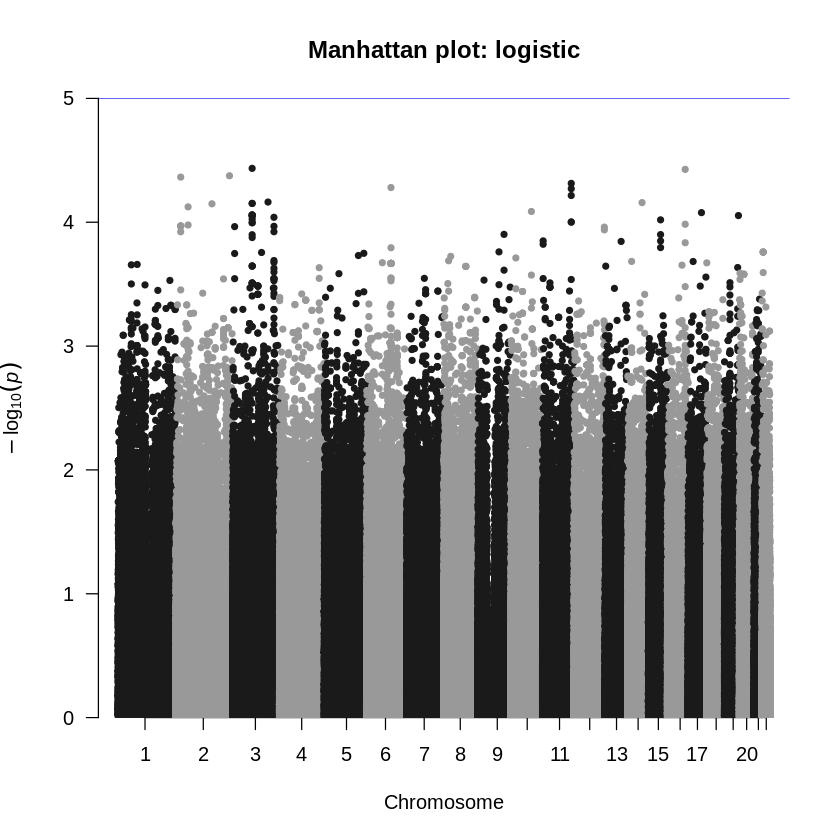

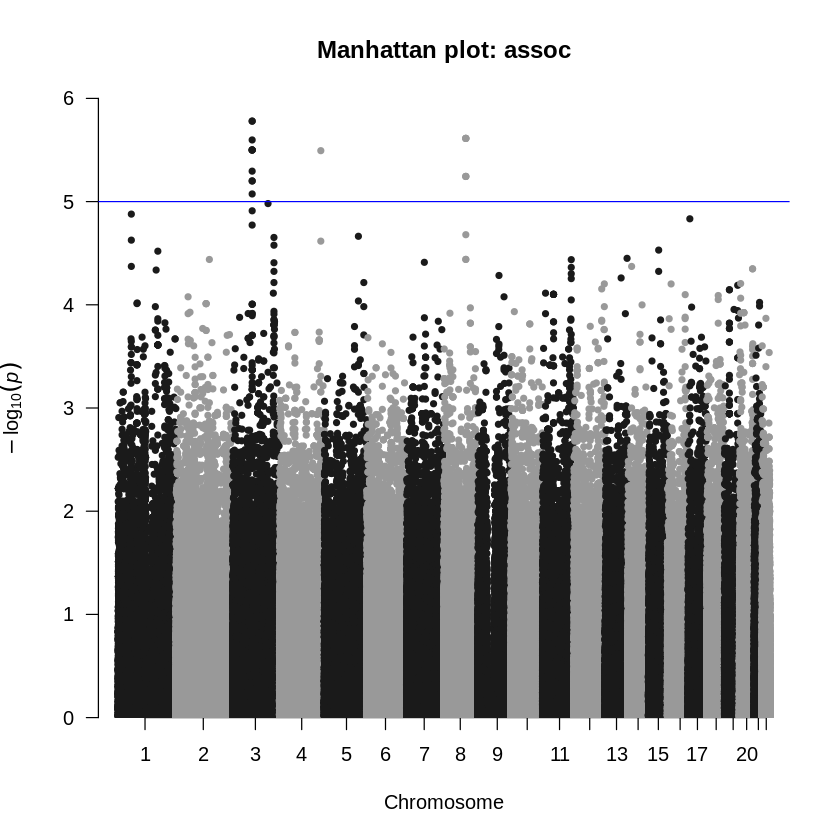

In [1]:
# Setup to avoid long messages and plot on screen
options(warn=-1)
options(jupyter.plot_mimetypes = 'image/png')

# Load GWAS package qqman
suppressMessages(library("qqman"))

# Manhattan plot using --logistic results
results_log <- read.table("Results/GWAS5/logistic_results.assoc_2.logistic", head=TRUE)
manhattan(results_log,chr="CHR",bp="BP",p="P",snp="SNP", main = "Manhattan plot: logistic")

# Manhattan plot using --assoc
results_as <- read.table("Results/GWAS5/assoc_results.assoc", head=TRUE)
manhattan(results_as,chr="CHR",bp="BP",p="P",snp="SNP", main = "Manhattan plot: assoc")  

:::{.callout-important title="Stop - Read - Solve"}

The blue line represents the threshold for significance (in the two plots, $10^{-5}$). We can see that there are no significant SNPs associated with the phenotype when we use the `--logistic` command (first plot). However, when we use the `--assoc` command (second plot), we obtain significant SNPs. 

Why is there a difference?

:::

:::{.callout-tip title="Solution" collapse="true"}

Recall from the beginning of this chapter that the `--assoc` command does not correct for covariates. So even though we have promising (and hopefully publishable!) results, this form of analysis may be flawed by the underlying population stratification, which is taken into account with the `--logistic` model. 

:::

The second method of visually determining significance is to use a [**QQ-plot**](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot). This plots the expected $-\log_{10}p$ value against the observed $-\log_{10}p$ value. It's a good way to observe not only outliers that could have significant associations but also peculiarities within our data. For example, if a plot suggests an extreme deviation between the x- and y-axes, then there might be an error with our analyses or data. 

We will create these plots using the qq() function from the qqman package in R.

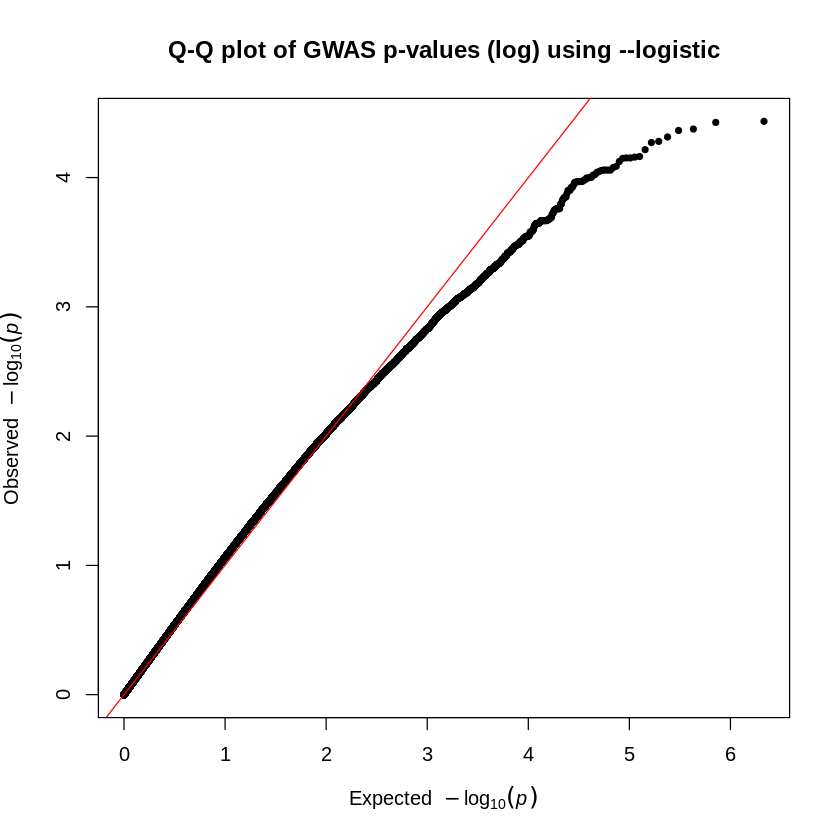

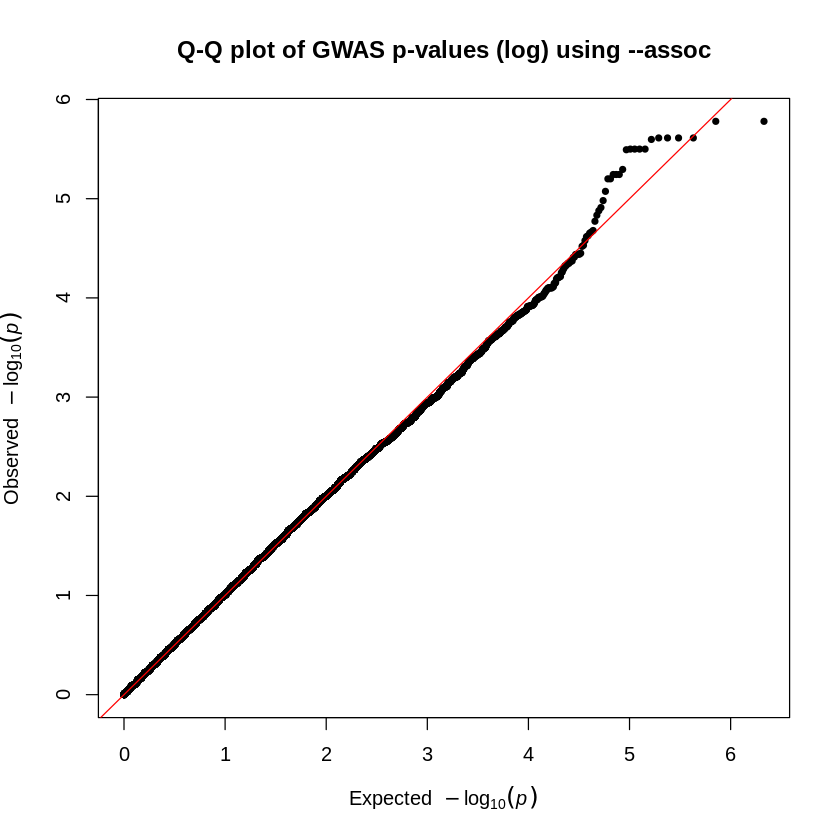

In [2]:
# Setup to avoid long messages and plot on screen
options(warn=-1)
options(jupyter.plot_mimetypes = 'image/png')

# Install and load GWAS package qqman
suppressMessages(library("qqman")) 

# QQ plot for --logistic
results_log <- read.table("Results/GWAS5/logistic_results.assoc_2.logistic", head=TRUE)
qq(results_log$P, main = "Q-Q plot of GWAS p-values (log) using --logistic")

# QQ plot for --assoc
results_as <- read.table("Results/GWAS5/assoc_results.assoc", head=TRUE)
qq(results_as$P, main = "Q-Q plot of GWAS p-values (log) using --assoc")

We can observe that in the upper half of the first plot (`--logistic`), the observed values are lower than the expected values. This pattern is consistent with what we see in the corresponding Manhattan plot. Additionally, examining the Q-Q plot generated from the `--assoc` command output reveals SNPs where the expected p-values exceed the observed p-values.

It's important to remember that, while this suggests an association between these SNPs and the studied phenotype, there isn't sufficient information here to determine the **causal variant**. In fact, there could potentially be multiple causal variants and the causal variants could be in LD with some of the significant variants. Identifying the causal variants would require further investigation using biological methods. However, this analysis has significantly reduced the number of SNPs that need to be studied.